In [2]:
!pip install git+https://github.com/tensorflow/examples.git

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/tensorflow/examples.git to /tmp/pip-req-build-gum3drv_
  Running command git clone --filter=blob:none --quiet https://github.com/tensorflow/examples.git /tmp/pip-req-build-gum3drv_
  Resolved https://github.com/tensorflow/examples.git to commit b97989359a4d76c5167291847a65b42e94ff4afe
  Preparing metadata (setup.py) ... done
  Created wheel for tensorflow-examples: filename=tensorflow_examples-b97989359a4d76c5167291847a65b42e94ff4afe_-py3-none-any.whl size=299720 sha256=2e0f879c59122366ad8842af6b3e73955f1fc787a8690eb208c7fc30871b41f9
  Stored in directory: /tmp/pip-ephem-wheel-cache-nago8u5i/wheels/08/f6/82/53a5b86c72bceebba962022c76037c95a9b2912f0719e5b9d2
Failed to build tensorflow-examples
  Running setup.py install for tensorflow-examples ... done
  DEPRECATION: tensorflow-examples was installed using the legacy 'setup.py install' method, because a wheel c

In [3]:
!pip install keras-unet-collection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.9/67.9 KB 5.2 MB/s eta 0:00:00


In [4]:
import tensorflow as tf
from tensorflow_examples.models.pix2pix import pix2pix
import os
import cv2
import glob
import numpy as np
from keras.models import Model
from keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate, Conv2DTranspose, BatchNormalization, Dropout, Lambda
from keras import backend as K
from keras_unet_collection import models
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

MODEL 1 - UNET default

In [ ]:
base_model = tf.keras.applications.MobileNetV2(input_shape=[256,256,3], include_top=False)

# Use the activations of these layers
layer_names = [
    'block_1_expand_relu',   # 64x64
    'block_3_expand_relu',   # 32x32
    'block_6_expand_relu',   # 16x16
    'block_13_expand_relu',  # 8x8
    'block_16_project',      # 4x4
]
base_model_outputs = [base_model.get_layer(name).output for name in layer_names]

# Create the feature extraction model
down_stack = tf.keras.Model(inputs=base_model.input, outputs=base_model_outputs)

down_stack.trainable = False

up_stack = [
    pix2pix.upsample(512, 3),  # 4x4 -> 8x8
    pix2pix.upsample(256, 3),  # 8x8 -> 16x16
    pix2pix.upsample(128, 3),  # 16x16 -> 32x32
    pix2pix.upsample(64, 3),   # 32x32 -> 64x64
]

def unet_model(output_channels:int):
  inputs = tf.keras.layers.Input(shape=[256,256, 3])

  # Downsampling through the model
  skips = down_stack(inputs)
  x = skips[-1]
  skips = reversed(skips[:-1])

  # Upsampling and establishing the skip connections
  for up, skip in zip(up_stack, skips):
    x = up(x)
    concat = tf.keras.layers.Concatenate()
    x = concat([x, skip])

  # This is the last layer of the model
  last = tf.keras.layers.Conv2DTranspose(
      filters=output_channels, kernel_size=3, strides=2,
      padding='same')  #64x64 -> 128x128

  x = last(x)

  return tf.keras.Model(inputs=inputs, outputs=x)

MODEL 2 - Multi U^2Net

In [16]:
model_u2 = models.u2net_2d((128, 128, 3), n_labels=1, 
                        filter_num_down=[64, 128, 256, 512], filter_num_up=[64, 64, 128, 256], 
                        filter_mid_num_down=[32, 32, 64, 128], filter_mid_num_up=[16, 32, 64, 128], 
                        filter_4f_num=[512, 512], filter_4f_mid_num=[256, 256], 
                        activation='ReLU', output_activation=None, 
                        batch_norm=True, pool=False, unpool=False, deep_supervision=True, name='u2net')

----------
The depth of u2net_2d = len(filter_num_down) + len(filter_4f_num) = 6
----------
deep_supervision = True
names of output tensors are listed as follows ("sup0" is the shallowest supervision layer;
"final" is the final output layer):

	u2net_output_sup0_trans_conv
	u2net_output_sup1_trans_conv
	u2net_output_sup2_trans_conv
	u2net_output_sup3_trans_conv
	u2net_output_sup4_trans_conv
	u2net_output_sup5_trans_conv
	u2net_output_final


MODEL 5 - R2UNet

In [ ]:
model_r2u = models.r2_unet_2d((128,128, 3), [64, 128, 256, 512], n_labels=1,
                          stack_num_down=2, stack_num_up=1, recur_num=2,
                          activation='ReLU', output_activation='Softmax', 
                          batch_norm=True, pool='max', unpool='nearest', name='r2unet')

MODEL 3 - Attention UNet 
from keras-unet-collection

In [5]:
model_att = models.att_unet_2d((128,128, 3), [64, 128, 256, 512], n_labels=1,
                           stack_num_down=2, stack_num_up=2,
                           activation='ReLU', atten_activation='ReLU', attention='add', output_activation=None, 
                           batch_norm=True, pool=False, unpool='bilinear', name='attunet')

MODEL 4 - UNet 3+ binary classification from keras-unet-collection

In [ ]:
model_u3 = models.unet_3plus_2d((128, 128, 3), n_labels=1, filter_num_down=[64, 128, 256, 512], 
                             filter_num_skip='auto', filter_num_aggregate='auto', 
                             stack_num_down=2, stack_num_up=1, activation='ReLU', output_activation='Sigmoid',
                             batch_norm=True, pool='max', unpool=False, deep_supervision=True, name='unet3plus')

Automated hyper-parameter determination is applied with the following details:
----------
	Number of convolution filters after each full-scale skip connection: filter_num_skip = [64, 64, 64]
	Number of channels of full-scale aggregated feature maps: filter_num_aggregate = 256
----------
deep_supervision = True
names of output tensors are listed as follows ("sup0" is the shallowest supervision layer;
"final" is the final output layer):

	unet3plus_output_sup0_activation
	unet3plus_output_sup1_activation
	unet3plus_output_sup2_activation
	unet3plus_output_final_activation


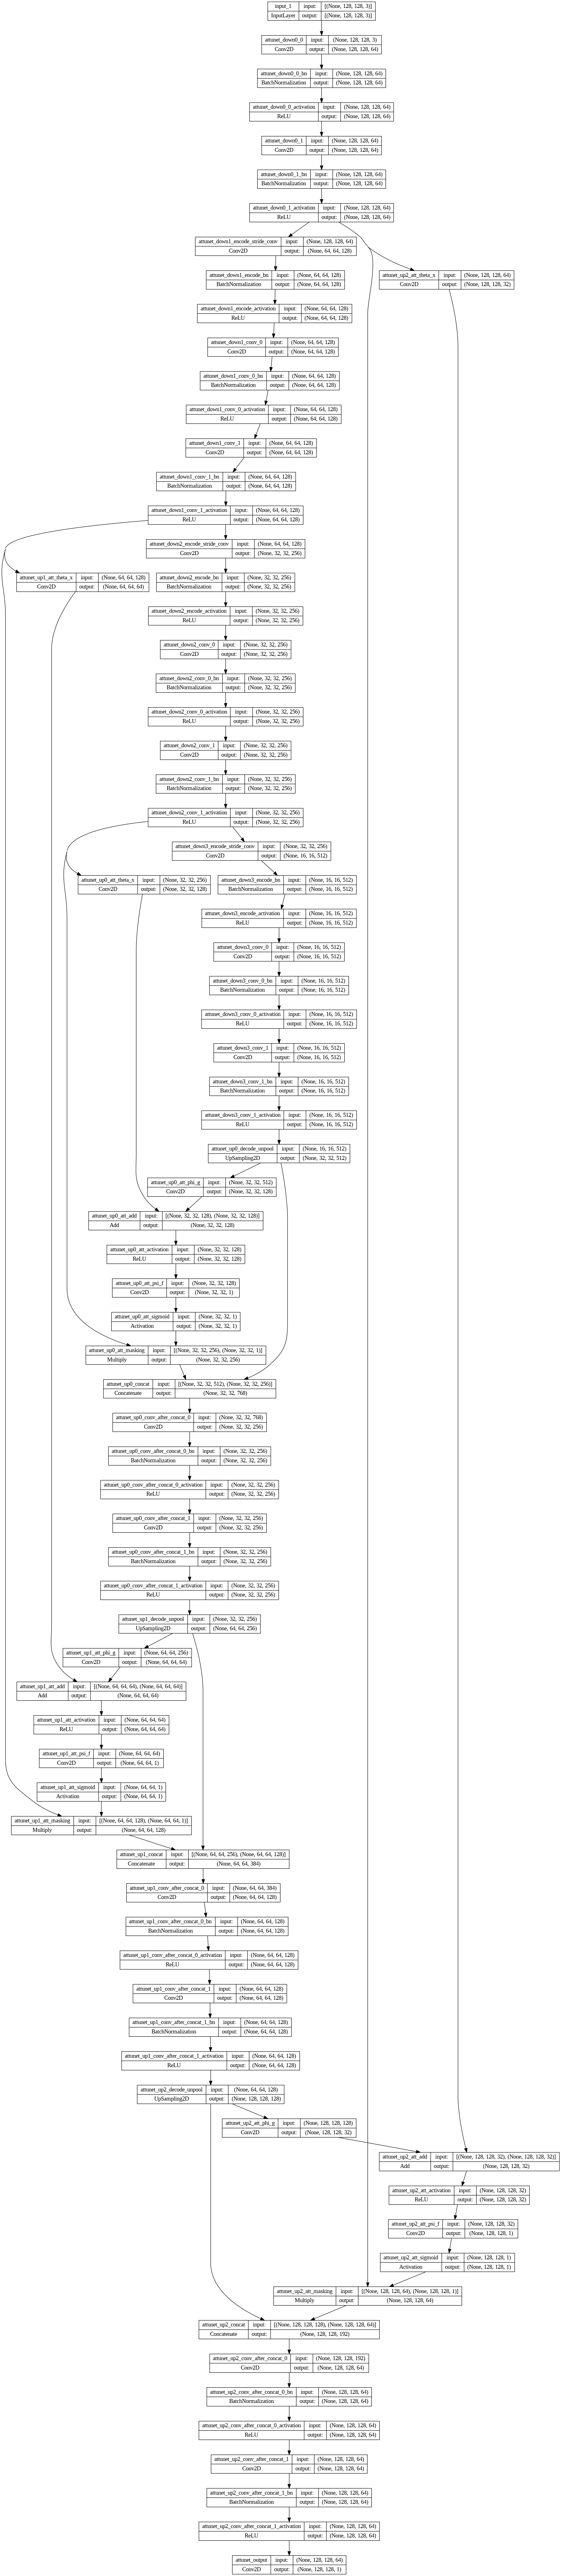

In [6]:
tf.keras.utils.plot_model(model_att, show_shapes = True)


In [7]:
image_names = glob.glob("/content/drive/MyDrive/Research_paper-2023/uavid-patches/uavid_patch_train/Images/*.png")
image_names.sort()
image_names_subset = image_names
images = [cv2.imread(img) for img in image_names_subset]
images = [cv2.resize(img, dsize=(128,128), interpolation=cv2.INTER_LINEAR) for img in images]
image_dataset = np.array(images)
# image_dataset = np.expand_dims(image_dataset, axis = 4)
image_dataset.shape

(496, 128, 128, 3)

In [ ]:
# image_dataset_bruh = image_dataset[:,:,:,:,0,0]
# image_dataset_bruh.shape

In [ ]:
# image_dataset = image_dataset_bruh

In [8]:
mask_names = glob.glob("/content/drive/MyDrive/Research_paper-2023/uavid-patches/uavid_patch_train/Masks/*.png")
mask_names.sort()
mask_names_subset = mask_names
masks = [cv2.imread(mask) for mask in mask_names_subset]
masks = [cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY) for mask in masks]
masks = [cv2.resize(mask, dsize=(128,128), interpolation=cv2.INTER_LINEAR) for mask in masks]
masks = [cv2.threshold(mask, 60, 255, cv2.THRESH_BINARY)[1] for mask in masks]
mask_dataset = np.array(masks)
mask_dataset = np.expand_dims(mask_dataset, axis = 3)
mask_dataset.shape

(496, 128, 128, 1)

In [9]:
print("Image data shape is: ", image_dataset.shape)
print("image dataset example shape is: ", image_dataset[0].shape)
print("Mask data shape is: ", mask_dataset.shape)
print("mnask dataset example shape is: ", mask_dataset[0].shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (496, 128, 128, 3)
image dataset example shape is:  (128, 128, 3)
Mask data shape is:  (496, 128, 128, 1)
mnask dataset example shape is:  (128, 128, 1)
Max pixel value in image is:  255
Labels in the mask are :  [  0 255]


In [10]:
#Normalize images
image_dataset = image_dataset /255.  #Can also normalize or scale using MinMax scaler
#Do not normalize masks, just rescale to 0 to 1.
mask_dataset = mask_dataset /255.  #Pixel values will be 0 or 1
X_train, X_test, y_train, y_test = train_test_split(image_dataset, mask_dataset, test_size = 0.20, random_state = 42)

In [11]:
print(X_train[0].shape)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(128, 128, 3)
(396, 128, 128, 3)
(396, 128, 128, 1)
(100, 128, 128, 3)
(100, 128, 128, 1)


In [12]:
print("Image data shape is: ", image_dataset.shape)
print("Mask data shape is: ", mask_dataset.shape)
print("Max pixel value in image is: ", image_dataset.max())
print("Labels in the mask are : ", np.unique(mask_dataset))

Image data shape is:  (496, 128, 128, 3)
Mask data shape is:  (496, 128, 128, 1)
Max pixel value in image is:  1.0
Labels in the mask are :  [0. 1.]


In [16]:
model_att.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# , 'Precision', tf.keras.metrics.AUC(), tf.keras.metrics.IoU(num_classes=1), tf.keras.metrics.F1Score()])

In [17]:
history = model_att.fit(X_train, y_train, 
                    verbose = 1,
                    epochs = 6,
                    validation_data = (X_test, y_test),
                    shuffle = False, 
                    batch_size = 16)

Epoch 1/6
25/25 [==============================] - 44s 621ms/step - loss: 0.4874 - accuracy: 0.8670 - val_loss: 1.7359 - val_accuracy: 0.8800
Epoch 2/6
25/25 [==============================] - 7s 269ms/step - loss: 0.2885 - accuracy: 0.8892 - val_loss: 0.5896 - val_accuracy: 0.8800
Epoch 3/6
25/25 [==============================] - 7s 269ms/step - loss: 0.2761 - accuracy: 0.8924 - val_loss: 0.3418 - val_accuracy: 0.8800
Epoch 4/6
25/25 [==============================] - 7s 265ms/step - loss: 0.2667 - accuracy: 0.8959 - val_loss: 0.3161 - val_accuracy: 0.8800
Epoch 5/6
25/25 [==============================] - 6s 257ms/step - loss: 0.2619 - accuracy: 0.8942 - val_loss: 0.3238 - val_accuracy: 0.8800
Epoch 6/6
25/25 [==============================] - 6s 253ms/step - loss: 0.2646 - accuracy: 0.8871 - val_loss: 0.3316 - val_accuracy: 0.8800


In [18]:
history.history

{'loss': [0.48740246891975403,
  0.2885485589504242,
  0.2760930359363556,
  0.26669326424598694,
  0.2619004547595978,
  0.26460447907447815],
 'accuracy': [0.8669723272323608,
  0.8892196416854858,
  0.8924460411071777,
  0.8959205746650696,
  0.8941792249679565,
  0.8870936036109924],
 'val_loss': [1.7359107732772827,
  0.589644730091095,
  0.3418240249156952,
  0.3161085844039917,
  0.3238200843334198,
  0.33163073658943176],
 'val_accuracy': [0.8800305128097534,
  0.8800305128097534,
  0.8800305128097534,
  0.8800305128097534,
  0.8800305128097534,
  0.8800305128097534]}

In [24]:
predictions = model_att.evaluate(X_test, y_test, verbose = 1, batch_size = 16)

7/7 [==============================] - 1s 69ms/step - loss: 0.3316 - accuracy: 0.8800


In [20]:
model_u2.save('/content/drive/MyDrive/Research_paper-2023/2023-Aerial-Segmentation-Paper/UsquareNet-128x128-3epochs.hdf5')

ru2net

In [23]:
model_r2u = models.r2_unet_2d((128,128, 3), [64, 128, 256, 512], n_labels=1,
                          stack_num_down=2, stack_num_up=1, recur_num=2,
                          activation='ReLU', output_activation='Softmax', 
                          batch_norm=True, pool='max', unpool='nearest', name='r2unet')

In [44]:
# model = multi_unet_model(n_classes=OUTPUT_CLASSES)

model_r2u.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy', 'Precision', tf.keras.metrics.AUC()])

In [ ]:
history_r = model_r2u.fit(X_train, y_train, 
                    verbose = 1,
                    epochs = 3,
                    validation_data = (X_test, y_test),
                    shuffle = False, 
                    batch_size = 16)

In [ ]:
history_r.history

In [ ]:
model_r2u.save('/content/drive/MyDrive/Research_paper-2023/2023-Aerial-Segmentation-Paper/RU2Net-128x128-3epochs.hdf5')

4/4 [==============================] - 64s 14s/step


In [27]:
predictions_np = np.array(predictions)

In [29]:
print("Max pixel value in image is: ", predictions_np.max())
print("Labels in the mask are : ", np.unique(predictions_np))

Max pixel value in image is:  0.99867207
Labels in the mask are :  [-0.9269148  -0.92640567 -0.92613125 ...  0.99788624  0.99816144
  0.99867207]


In [31]:
predictions_thresh = (predictions_np > 0.1).astype(np.uint8)

In [33]:
predictions_thresh[0].shape

(100, 128, 128, 1)

In [ ]:
predictions_images = predictions_thresh[0,:,:,:,:]
predictions_images1 = predictions_thresh[1,:,:,:,:]
predictions_images2 = predictions_thresh[2,:,:,:,:]
predictions_images3 = predictions_thresh[3,:,:,:,:]

predictions_avg = (predictions_images + predictions_images1) /2
print(predictions_images.shape,
predictions_images1.shape,
predictions_images2.shape,
predictions_images3.shape,
predictions_avg.shape)

In [ ]:
y_test.shape

In [ ]:
from tensorflow.keras.metrics import MeanIoU
n_classes = 2
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(predictions_images, y_test)
print("Mean IoU =", IOU_keras.result().numpy())

In [ ]:
print("Max pixel value in image is: ", predictions.max())
print("Labels in the mask are : ", np.unique(predictions))

Max pixel value in image is:  0.21117492
Labels in the mask are :  [-0.15148565 -0.1491074  -0.14879034 ...  0.20841813  0.20928112
  0.21117492]


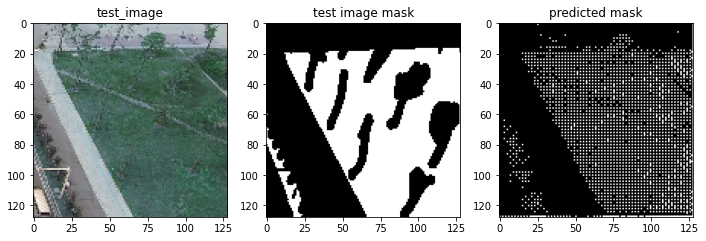

In [42]:
number = np.random.randint(0, len(X_test)-1)

plt.figure(figsize=(16, 8))
plt.subplot(241)
plt.title('test_image')
plt.imshow(X_test[number])

plt.subplot(242)
plt.title('test image mask')
plt.imshow(y_test[number], cmap = 'gray')

plt.subplot(243)
plt.title('predicted mask')
plt.imshow(predictions_thresh[0][number], cmap = 'gray')

# plt.subplot(244)
# plt.title('encoder output')
# plt.imshow(predictions[0][number], cmap = 'gray')
# plt.subplot(131)
# plt.title('predicted mask')
# plt.imshow(predictions_images1[number], cmap = 'gray')

# plt.subplot(132)
# plt.title('predicted mask')
# plt.imshow(predictions_images2[number], cmap = 'gray')

# plt.subplot(133)
# plt.title('predicted mask')
# plt.imshow(predictions_images3[number], cmap = 'gray')

In [ ]:
number

32

In [ ]:
model_att.save('/content/drive/MyDrive/Research_paper-2023/2023-Aerial-Segmentation-Paper/AttentionUNet-128x128-3epochs.hdf5')

In [ ]:
model_u3.save('/content/drive/MyDrive/Research_paper-2023/2023-Aerial-Segmentation-Paper/UNet3plus-128x128-3epochs.hdf5')

In [ ]:
predictions_thresh_color = (predictions_thresh*255).astype(np.uint8)

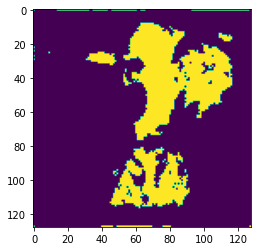

In [ ]:
plt.imshow(predictions_thresh_color[4])

In [ ]:
for count, prediction in enumerate(predictions_thresh_color) :
  filename = '/content/drive/MyDrive/Research_paper-2023/2023-Aerial-Segmentation-Paper/SavedModels/AttentionUNetPredictions/' +str(count) + '.jpg'
  cv2.imwrite(filename, prediction)

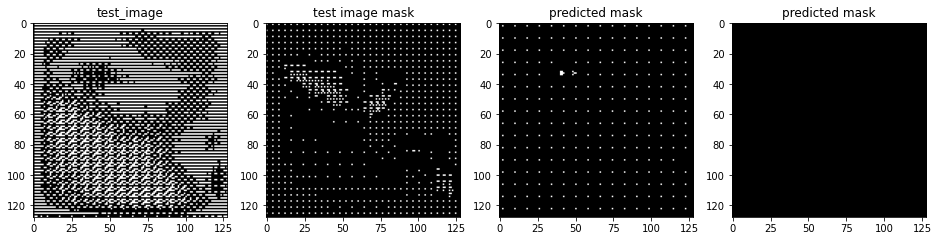

In [ ]:
plt.figure(figsize=(16, 8))
plt.subplot(241)
plt.title('test_image')
plt.imshow(predictions_images[number], cmap = 'gray')

plt.subplot(242)
plt.title('test image mask')
plt.imshow(predictions_images1[number], cmap = 'gray')

plt.subplot(243)
plt.title('predicted mask')
plt.imshow(predictions_images2[number], cmap = 'gray')

plt.subplot(244)
plt.title('predicted mask')
plt.imshow(predictions_images3[number], cmap = 'gray')